In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
from fastai import *
from fastai.tabular import *

In [3]:
rootpath=Path("../input/house-prices-advanced-regression-techniques")
train_path=rootpath/'train.csv'
test_path=rootpath/'test.csv'

In [4]:
train_df=pd.read_csv(train_path)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df=pd.read_csv(test_path).fillna(0)
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,...,120,0,0,MnPrv,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,...,0,0,0,MnPrv,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,...,144,0,0,0,0,0,1,2010,WD,Normal


In [6]:
procs=[FillMissing,Categorify]

In [7]:
dep_var='SalePrice'

cat_names=list(train_df.select_dtypes('object').columns.values)
cont_names=list(train_df.select_dtypes(['int64','float64']))
cont_names.remove('Id')
cont_names.remove('SalePrice')

In [8]:
test_db=TabularList.from_df(test_df,path=test_path,cont_names=cont_names,cat_names=cat_names)

In [10]:
valid_idx=list(range(500,700))
#.split_by_rand_pct(0.1)

In [11]:
data=(TabularList.from_df(train_df,path=train_path,cont_names=cont_names,cat_names=cat_names,procs=procs)
      .split_by_idx(valid_idx)
     .label_from_df(cols=dep_var,label_cls=FloatList,log=False)
     .add_test(test_db)
     .databunch())

In [12]:
data.show_batch(10)

MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target
RL,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,#na#,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,20.0000,67.0000,9808.0000,7.0000,5.0000,2002.0000,2002.0000,110.0000,788.0000,0.0000,785.0000,1573.0000,1573.0000,0.0000,0.0000,1573.0000,1.0000,0.0000,2.0000,0.0000,3.0000,1.0000,6.0000,0.0000,2002.0000,2.0000,544.0000,0.0000,72.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,2009.0000,227000.0
RL,Pave,#na#,Reg,Low,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,Gable,CompShg,HdBoard,Plywood,None,TA,TA,CBlock,TA,TA,Av,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,#na#,Attchd,Unf,TA,TA,P,#na#,#na#,#na#,WD,Normal,False,False,False,90.0000,100.0000,25000.0000,5.0000,4.0000,1967.0000,1967.0000,0.0000,0.0000,0.0000,1632.0000,1632.0000,1632.0000,0.0000,0.0000,1632.0000,0.0000,0.0000,2.0000,0.0000,4.0000,2.0000,8.0000,0.0000,1967.0000,2.0000,576.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,2007.0000,143000.0
RM,Pave,#na#,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,WdShing,Wd Shng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,BuiltIn,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,50.0000,50.0000,6000.0000,6.0000,7.0000,1929.0000,1950.0000,0.0000,0.0000,0.0000,862.0000,862.0000,950.0000,208.0000,0.0000,1158.0000,0.0000,0.0000,1.0000,0.0000,3.0000,1.0000,5.0000,1.0000,1929.0000,1.0000,208.0000,0.0000,0.0000,112.0000,0.0000,0.0000,0.0000,0.0000,7.0000,2008.0000,120000.0
RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,20.0000,85.0000,14536.0000,8.0000,5.0000,2002.0000,2003.0000,236.0000,1300.0000,0.0000,316.0000,1616.0000,1629.0000,0.0000,0.0000,1629.0000,1.0000,0.0000,2.0000,0.0000,3.0000,1.0000,9.0000,1.0000,2002.0000,3.0000,808.0000,0.0000,252.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.0000,2007.0000,270000.0
RM,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,BLQ,GasA,Ex,Y,SBrkr,TA,Typ,#na#,Detchd,Unf,TA,TA,Y,#na#,#na#,#na#,WD,Partial,False,False,False,20.0000,50.0000,6000.0000,5.0000,5.0000,1948.0000,1950.0000,0.0000,104.0000,169.0000,516.0000,789.0000,789.0000,0.0000,0.0000,789.0000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,5.0000,0.0000,1948.0000,1.0000,250.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,2008.0000,115000.0
RL,Pave,#na#,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,Gd,PConc,Gd,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Abnorml,True,False,False,60.0000,70.0000,14541.0000,8.0000,7.0000,1993.0000,1993.0000,0.0000,1012.0000,0.0000,326.0000,1338.0000,1352.0000,1168.0000,0.0000,2520.0000,1.0000,0.0000,2.0000,1.0000,5.0000,1.0000,10.0000,1.0000,1993.0000,3.0000,796.0000,209.0000,55.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.0000,2006.0

In [13]:
learn=tabular_learner(data,layers=[4000,2000],metrics=[mean_absolute_error],path='.')

In [14]:
learn.fit_one_cycle(5,.01)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,38527610880.000000,42225254400.000000,185053.937500,00:01
1,38584422400.000000,42067169280.000000,185050.140625,00:00
2,38413729792.000000,42166824960.000000,185632.140625,00:00
3,38339678208.000000,41859854336.000000,184948.953125,00:00
4,38245224448.000000,41692614656.000000,184514.125000,00:00


In [15]:
learn.save('stage1')

In [16]:
learn.load('stage1');

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


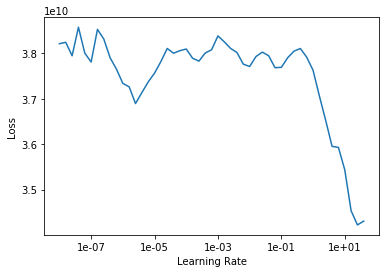

In [19]:
learn.lr_find(1e-10,1e+10)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(20,10)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,20572669952.000000,686837923840.000000,447369.875000,00:00
1,10955769856.000000,45929095168.000000,208749.078125,00:00
2,6920136704.000000,3178805760.000000,39176.523438,00:00
3,4797839872.000000,76661465088.000000,273742.656250,00:00
4,3988964864.000000,52896888520704.000000,7117637.000000,00:00
5,3253170432.000000,9052376064.000000,74507.921875,00:00
6,2910268672.000000,4918836736.000000,59811.726562,00:00
7,2837627904.000000,3907685888.000000,42465.945312,00:00
8,2493002240.000000,2622240768.000000,37216.003906,00:00
9,2225668352.000000,5816185856.000000,67149.718750,00:00


In [ ]:
learn.validate(data.valid_dl)

In [ ]:
sub_df = pd.DataFrame(columns=['Id','SalePrice']).astype({'Id':int,'SalePrice':float})

In [ ]:
for index, rw in test_df.iterrows():
    price=learn.predict(rw)[0].obj[0]
    sub_df.loc[index]=[int(rw.Id),price]

In [ ]:
sub_df=sub_df.astype({'Id':int,'SalePrice':float})
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv',index=False)